In [ ]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

In [ ]:
def get_data():
    x = pd.read_csv('dataset_tissue.txt', index_col=None)
    x = x.drop(x.columns[0], axis=1)

    labels = pd.read_csv('clase.txt', skiprows=1, names=["index", "label"])
    labels = labels.drop("index", axis=1)

    y = np.array(labels["label"])
    x = np.array(x.iloc[:, :]).T
    return x, y

In [ ]:
x, y = get_data()
n_labels = len(np.unique(y))

In [ ]:
# Assuming x is your data and y is your labels
data = x  # Replace with your actual data
labels = y  # Replace with your actual labels

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

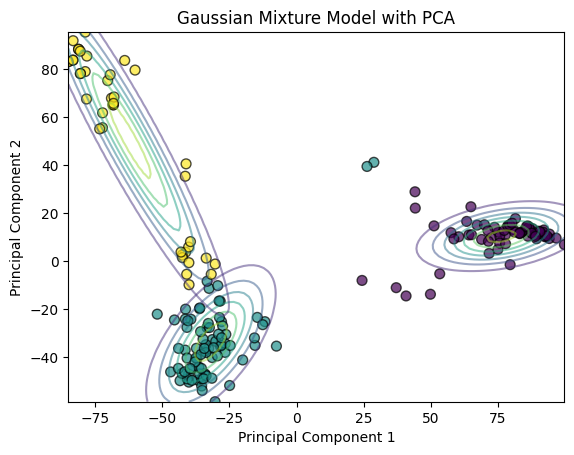

In [ ]:
class GMM:
    def __init__(self, num_components=3, num_iterations=100, tol=1e-4):
        self.num_components = num_components
        self.num_iterations = num_iterations
        self.tol = tol
        self.means = None
        self.covariances = None
        self.weights = None

    def fit(self, data):
        n_samples, _ = data.shape
        self.means = [data[i] for i in range(self.num_components)]
        self.covariances = [np.cov(data.T) for _ in range(self.num_components)]
        self.weights = [1.0 / self.num_components for _ in range(self.num_components)]

        for iteration in range(self.num_iterations):
            # E
            responsibilities = self.e_step(data)

            # M
            total_resp = responsibilities.sum(axis=0)

            for c in range(self.num_components):
                self.means[c] = (data.T @ responsibilities[:, c]) / total_resp[c]
                self.covariances[c] = np.dot((responsibilities[:, c] * (data - self.means[c]).T),
                                             (data - self.means[c])) / total_resp[c]
                self.weights[c] = total_resp[c] / n_samples

        return np.argmax(responsibilities, axis=1)

    def e_step(self, data):
        responsibilities = np.zeros((data.shape[0], self.num_components))

        for c in range(self.num_components):
            diff = data - self.means[c]
            cov_inv = np.linalg.pinv(self.covariances[c])
            exponent = -0.5 * np.sum(diff @ cov_inv * diff, axis=1)
            coef = 1 / ((2 * np.pi) ** (data.shape[1] / 2) * np.sqrt(np.linalg.det(self.covariances[c])))
            responsibilities[:, c] = self.weights[c] * coef * np.exp(exponent)

        responsibilities /= responsibilities.sum(axis=1, keepdims=True)

        return responsibilities


gmm = GMM(num_components=3)
labels = gmm.fit(data_pca)

plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='viridis', s=50, edgecolors='k', alpha=0.7)

x_range = np.linspace(np.min(data_pca[:, 0]), np.max(data_pca[:, 0]), 100)
y_range = np.linspace(np.min(data_pca[:, 1]), np.max(data_pca[:, 1]), 100)
x, y = np.meshgrid(x_range, y_range)
pos = np.dstack((x, y))

for c in range(gmm.num_components):
    plt.contour(x, y, multivariate_normal.pdf(pos, gmm.means[c], gmm.covariances[c]), alpha=0.5)

plt.title('Gaussian Mixture Model with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

Silhouette Score: 0.6958298085751841
Normalized Mutual Information: 0.6095311952925803
Adjusted Rand Index: 0.4073244900518393


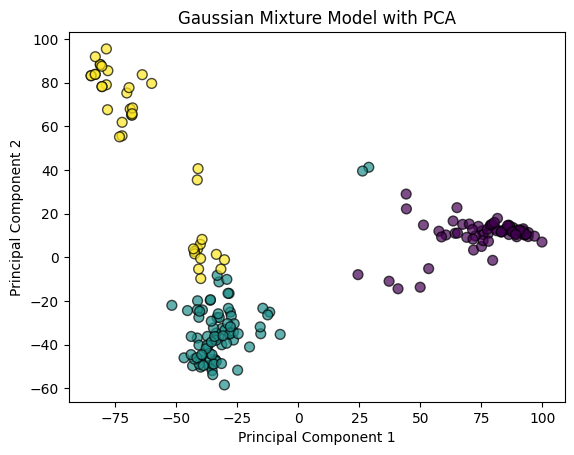

In [ ]:
from sklearn.metrics import silhouette_score, normalized_mutual_info_score, adjusted_rand_score

gmm = GMM(num_components=3)
labels = gmm.fit(data_pca)

plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='viridis', s=50, edgecolors='k', alpha=0.7)

le = LabelEncoder()
y_true = le.fit_transform(y.reshape(-1))

# Silhouette Score
silhouette_avg = silhouette_score(data_pca, labels)
print(f"Silhouette Score: {silhouette_avg}")

# Normalized Mutual Information (NMI)
nmi = normalized_mutual_info_score(y_true, labels)
print(f"Normalized Mutual Information: {nmi}")

# Rand Index
rand_index = adjusted_rand_score(y_true, labels)
print(f"Adjusted Rand Index: {rand_index}")

plt.title('Gaussian Mixture Model with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
